## Yield Spread Model 


This notebook implements the model to predict the yield spread using the reference data and trade history

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns


from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor
import lightgbm

from IPython.display import display, HTML
import os

import wandb
from wandb.keras import WandbCallback


from ficc.data.process_data import process_data
from ficc.utils.gcp_storage_functions import upload_data, download_data

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Setting the seed for layer initializer

In [3]:
layer_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1, seed=10)

Setting up the credentials for GCP

In [4]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/gil/ficc/creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

Initializing the big query client

In [5]:
bq_client = bigquery.Client()

In [6]:
storage_client = storage.Client()

Checking if GPU is available

In [7]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

#### Hyper-parameters for the model

The batch size and learning rate have an impact on the smoothness of convergence of the model.\
Larger the batch size the smoother the convergence. For a larger batch size we need a higher learning rate and vice-versa

In [8]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.0001
BATCH_SIZE = 1000
NUM_EPOCHS = 100

DROPOUT = 0.01
SEQUENCE_LENGTH = 5
NUM_FEATURES = 5

#### Data Preparation
We grab the data from BigQuery and convert it into a format suitable for input to the model. We save the processed data as a pickle file on a GCP bucket.

The trade history is an array which contains the yield spread, trade type, trade size, and the number of seconds ago the trade occured. 

In [9]:
%%time
import gcsfs
fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
with fs.open('ficc_models_training_data/processed_data_ficc_2022_trades_min_trades_in_hist_0_2022-05-23-04:28.pkl') as f:
    data = pd.read_pickle(f)

CPU times: user 3min 17s, sys: 36.9 s, total: 3min 54s
Wall time: 8min 10s


### Adding target trade features to calculate attention

As a first step, we only utilize the size of the trade and the directions as features to calculate the attention. Going forward we will be adding more features like the state code, coupon, interest payment frequency, etc. 

In [10]:
def target_trade_processing_for_attention(row):
    trade_mapping = {'D':[0,0], 'S':[0,1], 'P':[1,0]}
    target_trade_features = []
    target_trade_features.append(row['quantity'])
    target_trade_features = target_trade_features + trade_mapping[row['trade_type']]
    return np.tile(target_trade_features, (5,1))

In [11]:
%%time
data['target_attention_features'] = data.apply(target_trade_processing_for_attention, axis = 1)

CPU times: user 7min 47s, sys: 10.5 s, total: 7min 58s
Wall time: 7min 58s


In [12]:
data.purpose_sub_class.fillna(0, inplace=True)

In [39]:
for c in data.columns.to_list():
    print(c)

MSRB_maturity_date
MSRB_coupon_rate
msrb_cusip
yield_spread
calc_price
price_to_next_call
price_to_par_call
price_to_maturity
calc_date
price_delta
issue_key
series_id
trade_id
row_number
calc_day_cat
num_prev_messages
MSRB_INST_ORDR_DESC
MSRB_valid_from_date
MSRB_valid_to_date
trade_datetime
publish_datetime
upload_date
sequence_number
rtrs_control_number
trade_type
transaction_type
security_description
dated_date
when_issued
assumed_settlement_date
trade_date
time_of_trade
settlement_date
par_traded
dollar_price
yield
brokers_broker
is_weighted_average_price
is_lop_or_takedown
publish_date
publish_time
version
unable_to_verify_dollar_price
is_alternative_trading_system
is_non_transaction_based_compensation
is_trade_with_a_par_amount_over_5MM
coupon
issue_key_copy
id
cusip
ref_valid_from_date
ref_valid_to_date
incorporated_state_code
organization_primary_name
ice_organization_id
instrument_primary_name
issue_text
conduit_obligor_name
is_called
is_callable
called_redemption_date
first_

We train the model on a subset of features. These features are defined below

In [14]:
# features: 
IDENTIFIERS = ['rtrs_control_number', 'cusip']

################ Base features ##################
BINARY = ['callable',
          'sinking',
          'zerocoupon',
          'is_non_transaction_based_compensation',
          'is_general_obligation',
          'callable_at_cav',           
          'extraordinary_make_whole_call', 
          'make_whole_call',
          'has_unexpired_lines_of_credit',
          'escrow_exists',
          ]

CATEGORICAL_FEATURES = ['rating',
                        'incorporated_state_code',
                        'trade_type',
                        'purpose_class']

NON_CAT_FEATURES = ['quantity',
                    'days_to_maturity',
                    'days_to_call',
                    'coupon',
                    'issue_amount',
                    'last_seconds_ago',
                    'last_yield_spread',
                    'days_to_settle',
                    'days_to_par',
                    'maturity_amount',
                    'issue_price', 
                    'orig_principal_amount',
                    'max_amount_outstanding',
                    'accrued_days',
                    'days_in_interest_payment',
                    'A/E']

TRADE_HISTORY = ['trade_history', 'target_attention_features']
TARGET = ['yield_spread']


################ Base features end ##################

################ Add features here ##################

# BINARY += ['callable_at_cav',           
#            'extraordinary_make_whole_call', 
#            'make_whole_call',
#            'has_unexpired_lines_of_credit',
#            'escrow_exists',
#           ]

# CATEGORICAL_FEATURES += ['transaction_type','maturity_description_code','purpose_class']


PREDICTORS = BINARY + CATEGORICAL_FEATURES + NON_CAT_FEATURES + TARGET + TRADE_HISTORY

In [15]:
processed_data = data[IDENTIFIERS + PREDICTORS + ['dollar_price','calc_date', 'trade_date','trade_datetime', 'purpose_sub_class', 'called_redemption_type', 'calc_day_cat']]

In [16]:
len(processed_data)

3038933

In [17]:
processed_data = processed_data[~processed_data.purpose_sub_class.isin([6, 20, 21, 22, 44, 57, 90, 106])]

In [18]:
processed_data = processed_data[~processed_data.called_redemption_type.isin([18, 19])]

In [19]:
len(processed_data)

2971283

#### Fitting encoders to the categorical features. These encoders are then used to encode the categorical features of the train and test set

In [20]:
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

Splitting the date into train and test set

In [21]:
train_dataframe = processed_data[processed_data.trade_date < '05-01-2022']
test_dataframe = processed_data[(processed_data.trade_date >= '05-01-2022')]

In [22]:
len(train_dataframe)

2536551

In [23]:
len(test_dataframe)

434732

Converting data into format suitable for the model

In [24]:
def create_input(df):
    global encoders
    datalist = []
    datalist.append(np.stack(df['trade_history'].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

In [25]:
%%time
x_train = create_input(train_dataframe)
y_train = train_dataframe.yield_spread

CPU times: user 9.34 s, sys: 276 ms, total: 9.62 s
Wall time: 9.61 s


In [26]:
%%time
x_test = create_input(test_dataframe)
y_test = test_dataframe.yield_spread

CPU times: user 1.64 s, sys: 3.62 ms, total: 1.64 s
Wall time: 1.64 s


In [27]:
x_train[1].shape

(2536551, 5, 3)

In [28]:
x_test[2].shape

(434732, 26)

#### Adapting Normalization layers to the non categorical features


In [29]:
# Normalization layer for the trade history
trade_history_normalizer = Normalization(name='Trade_history_normalizer')
trade_history_normalizer.adapt(x_train[0])

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
# Normalization layer for the non-categorical and binary features
noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
noncat_binary_normalizer.adapt(x_train[2])

#### Attention layer
This is an implementation of a layer that calculates scaled dot product attention. 

In [ ]:
class CustomAttention(tf.keras.layers.Layer):
    def __init__(self, depth):
        super(CustomAttention, self).__init__()
        self.depth = depth
        self.wq = layers.Dense(depth, kernel_initializer=layer_initializer, name='weights_query') 
        self.wk = layers.Dense(depth, kernel_initializer=layer_initializer, name='weights_key')
        self.wv = layers.Dense(depth, kernel_initializer=layer_initializer, name='weights_value')

    def scaled_dot_product_attention(self, q, v, k):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        scaling = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(scaling)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=1) 
        output = tf.matmul(attention_weights, v)
        
        return output
    
    def call(self, q, v, k):
        
        q = self.wq(q)
        v = self.wv(v)
        k = self.wk(k)

        output = self.scaled_dot_product_attention(q, v, k)
        
        return output    

#### Implementation of the model


In [ ]:
inputs = []
layer = []

############## INPUT BLOCK ###################
trade_history_input = layers.Input(name="trade_history_input", 
                                   shape=(SEQUENCE_LENGTH,NUM_FEATURES), 
                                   dtype = tf.float32) 

target_attention_input = layers.Input(name="target_attention_input", 
                                   shape=(SEQUENCE_LENGTH, 3), 
                                   dtype = tf.float32) 


inputs.append(trade_history_input)
inputs.append(target_attention_input)

inputs.append(layers.Input(
    name="NON_CAT_AND_BINARY_FEATURES",
    shape=(len(NON_CAT_FEATURES + BINARY),)
))


layer.append(noncat_binary_normalizer(inputs[2]))
####################################################


############## TRADE HISTORY MODEL #################

# Adding the time2vec encoding to the input to transformer
lstm_layer = layers.LSTM(50, 
                         activation='tanh',
                         input_shape=(SEQUENCE_LENGTH,NUM_FEATURES),
                         kernel_initializer = layer_initializer,
                         return_sequences = True,
                         name='LSTM')

# lstm_attention_layer = layers.Attention(use_scale=True, name='attention_layer_1')
lstm_attention_layer = CustomAttention(50)

lstm_layer_2 = layers.LSTM(100, 
                           activation='tanh',
                           input_shape=(SEQUENCE_LENGTH,50),
                           kernel_initializer = layer_initializer,
                           return_sequences = False,
                           name='LSTM_2')


features = lstm_layer(trade_history_normalizer(inputs[0]))
# features = lstm_attention_layer([features, features])
features = lstm_attention_layer(features, features, inputs[1])
features = layers.BatchNormalization()(features)
# features = layers.Dropout(DROPOUT)(features)

features = lstm_layer_2(features)
features = layers.BatchNormalization()(features)
# features = layers.Dropout(DROPOUT)(features)

trade_history_output = layers.Dense(100, 
                                    activation='relu',
                                    kernel_initializer=layer_initializer)(features)

####################################################

############## REFERENCE DATA MODEL ################
global encoders
for f in CATEGORICAL_FEATURES:
    fin = layers.Input(shape=(1,), name = f)
    inputs.append(fin)
    embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                    output_dim = int(np.sqrt(fmax[f])),
                                                                    input_length= 1,
                                                                    name = f + "_embed",
                                                                    embeddings_initializer=layer_initializer)(fin))
    layer.append(embedded)

    
reference_hidden = layers.Dense(400,activation='relu',kernel_initializer=layer_initializer,name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

reference_hidden = layers.BatchNormalization()(reference_hidden)
reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

reference_hidden2 = layers.Dense(200,activation='relu',kernel_initializer=layer_initializer,name='reference_hidden_2')(reference_hidden)
reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

reference_output = layers.Dense(100,activation='tanh',kernel_initializer=layer_initializer,name='reference_hidden_3')(reference_hidden2)

####################################################

feed_forward_input = layers.concatenate([reference_output, trade_history_output])

hidden = layers.Dense(300,activation='relu',kernel_initializer=layer_initializer)(feed_forward_input)
hidden = layers.BatchNormalization()(hidden)
hidden = layers.Dropout(DROPOUT)(hidden)

hidden2 = layers.Dense(100,activation='tanh',kernel_initializer=layer_initializer)(hidden)
hidden2 = layers.BatchNormalization()(hidden2)
hidden2 = layers.Dropout(DROPOUT)(hidden2)

final = layers.Dense(1,kernel_initializer=layer_initializer)(hidden2)

model = keras.Model(inputs=inputs, outputs=final)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rating (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 incorporated_state_code (Input  [(None, 1)]         0           []                               
 Layer)                                                                                           
                                                                                                  
 trade_type (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 purpose_class (InputLayer)     [(None, 1)]          0           []                           

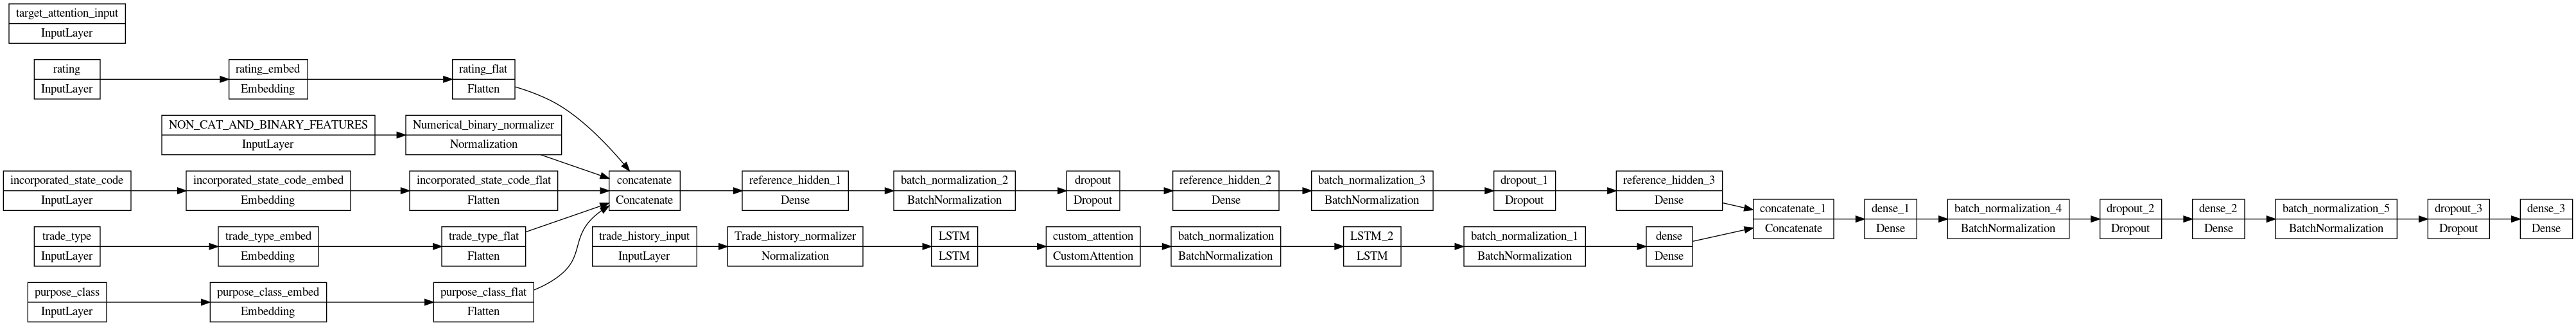

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [ ]:
fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True,
    )
]

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError(),
          metrics=[keras.metrics.MeanAbsoluteError()])

In [ ]:
%%time 
history = model.fit(x_train,y_train,epochs=100,batch_size=BATCH_SIZE,verbose=1,validation_split=0.1,callbacks=fit_callbacks)

Epoch 1/100
2283/2283 [==============================] - 39s 13ms/step - loss: 45.8463 - mean_absolute_error: 45.8463 - val_loss: 39.1032 - val_mean_absolute_error: 39.1032
Epoch 2/100
2283/2283 [==============================] - 28s 12ms/step - loss: 27.0469 - mean_absolute_error: 27.0469 - val_loss: 17.5053 - val_mean_absolute_error: 17.5053
Epoch 3/100
2283/2283 [==============================] - 26s 11ms/step - loss: 12.4088 - mean_absolute_error: 12.4088 - val_loss: 9.1602 - val_mean_absolute_error: 9.1602
Epoch 4/100
2283/2283 [==============================] - 26s 11ms/step - loss: 11.1635 - mean_absolute_error: 11.1635 - val_loss: 8.9198 - val_mean_absolute_error: 8.9198
Epoch 5/100
2283/2283 [==============================] - 26s 11ms/step - loss: 10.9384 - mean_absolute_error: 10.9384 - val_loss: 8.8248 - val_mean_absolute_error: 8.8248
Epoch 6/100
2283/2283 [==============================] - 26s 11ms/step - loss: 10.7969 - mean_absolute_error: 10.7969 - val_loss: 8.6666 - va

### Test accuracy on the entire test set

In [ ]:
_, mae = model.evaluate(x_test, y_test, verbose=1)
print(f"Test loss: {round(mae, 3)}")

13586/13586 [==============================] - 50s 4ms/step - loss: 13.9588 - mean_absolute_error: 13.9588
Test loss: 13.959


### Test accuracy on large dealer-dealer trades
We define large as any trade which is above $500,000

In [ ]:
true_mid = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))] # & (test_dataframe.days_to_call >= np.log10(360))]

In [ ]:
len(true_mid)

5900

In [ ]:
%%time
x_true_mid = create_input(true_mid)
y_true_mid = true_mid.yield_spread

CPU times: user 34.2 ms, sys: 0 ns, total: 34.2 ms
Wall time: 33.5 ms


In [ ]:
_, mae = model.evaluate(x_true_mid, y_true_mid, verbose=1)
print(f"Test MAE: {round(mae, 3)}")

185/185 [==============================] - 1s 4ms/step - loss: 10.8837 - mean_absolute_error: 10.8837
Test MAE: 10.884


#### Plotting validation loss vs training loss

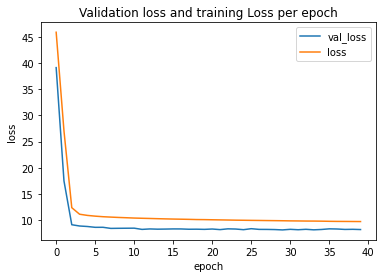

In [ ]:
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## LightGBM 

In [ ]:
def gbmprep(df):
    df[CATEGORICAL_FEATURES ] = df[CATEGORICAL_FEATURES].astype('category')
    df[NON_CAT_FEATURES + BINARY] = df[NON_CAT_FEATURES + BINARY].astype('float64')
    df = df.drop(columns = ['trade_history','target_attention_features','yield_spread'])
    return df

In [ ]:
trainlabel = train_dataframe.yield_spread
testlabel = test_dataframe.yield_spread

In [ ]:
gbt_td = gbmprep(train_dataframe[PREDICTORS])

In [ ]:
gbtmodel = LGBMRegressor(num_iterations=300, max_depth=12, num_leaves=300, objective='mae', verbosity=-1)

In [ ]:
%%time 
gbtmodel.fit(gbt_td, trainlabel)


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


CPU times: user 11min 37s, sys: 0 ns, total: 11min 37s
Wall time: 25 s


LGBMRegressor(max_depth=12, num_iterations=300, num_leaves=300, objective='mae',
              verbosity=-1)

In [ ]:
%%time 
gbt_pred = gbtmodel.predict( gbmprep(test_dataframe[PREDICTORS]) )
delta = testlabel - gbt_pred
print( delta.mean(), delta.abs().mean() )

-2.6027785234005294 18.73960103666872
CPU times: user 39.1 s, sys: 0 ns, total: 39.1 s
Wall time: 1.66 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

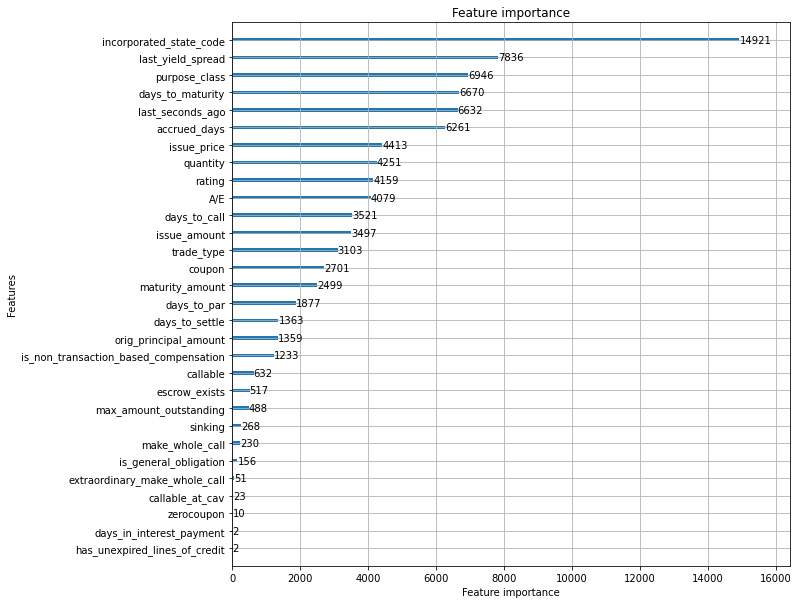

In [ ]:
lightgbm.plot_importance(gbtmodel, figsize=(10,10))

## Evaluation of results

In [ ]:
encarray = create_input(train_dataframe)
%time preds = model.predict(encarray)
preds = preds.reshape(len(preds))

error = train_dataframe.yield_spread - preds

CPU times: user 6min 51s, sys: 1min 8s, total: 8min
Wall time: 4min 7s


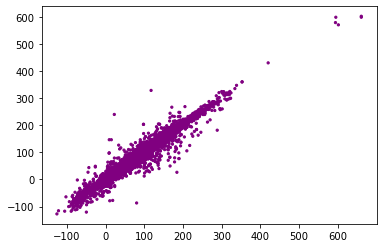

In [ ]:
from matplotlib.colors import to_rgb, to_rgba
threshold = 1e6

# plot points with transparency depending on size of trade
def drawpoints(preds, target, train_dataframe):
    #Only draw Dealer-Dealer trades
    r, g, b = to_rgb('purple')
    keep = (10**train_dataframe.quantity > threshold) & (train_dataframe.trade_type == 'D')  # save time by not plotting points that would be invisible
    w = np.minimum( np.array(10**train_dataframe.quantity[keep]), threshold)
    opacity = w/threshold
    color = [(r, g, b, alpha) for alpha in opacity]
    plt.scatter(preds[keep], target[keep], s=5, c=color)
    
plt.figure()
drawpoints(preds, train_dataframe.yield_spread, train_dataframe)

In [ ]:
test_preds = model.predict(create_input(test_dataframe))

In [ ]:
evaluation_dataframe = test_dataframe.copy()
evaluation_dataframe['predicted_yield_spreads'] = test_preds
evaluation_dataframe['delta_yield_spreads'] = evaluation_dataframe.yield_spread - evaluation_dataframe.predicted_yield_spreads

In [ ]:
evaluation_dataframe.days_to_maturity = 10**evaluation_dataframe.days_to_maturity
evaluation_dataframe.days_to_call = 10**evaluation_dataframe.days_to_call
evaluation_dataframe.quantity = 10**evaluation_dataframe.quantity
evaluation_dataframe.sort_values('delta_yield_spreads', ascending=False)

,rtrs_control_number,cusip,callable,sinking,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,callable_at_cav,extraordinary_make_whole_call,make_whole_call,...,target_attention_features,dollar_price,calc_date,trade_date,trade_datetime,purpose_sub_class,called_redemption_type,calc_day_cat,predicted_yield_spreads,delta_yield_spreads
12656,2022052007576800,54589SGH1,True,False,False,False,False,False,False,False,...,"[[4.397940158843994, 1.0, 0.0], [4.39794015884...",3.181,2036-12-01,2022-05-20,2022-05-20 13:04:53,53.0,0.0,2,57.294254,8971.404458
12655,2022052007577000,54589SGH1,True,False,False,False,False,False,False,False,...,"[[4.397940158843994, 0.0, 0.0], [4.39794015884...",3.431,2036-12-01,2022-05-20,2022-05-20 13:04:53,53.0,0.0,2,50.387348,8300.411364
12654,2022052007558000,54589SGH1,True,False,False,False,False,False,False,False,...,"[[4.397940158843994, 0.0, 1.0], [4.39794015884...",3.531,2036-12-01,2022-05-20,2022-05-20 13:04:55,53.0,0.0,2,41.802113,8064.896600
293352,2022051011437500,303823KF4,False,True,False,False,False,False,False,False,...,"[[4.176091194152832, 0.0, 0.0], [4.17609119415...",99.450,2022-05-15,2022-05-10,2022-05-10 14:21:24,48.0,3.0,3,269.710205,6483.425029
293351,2022051011436700,303823KF4,False,True,False,True,False,False,False,False,...,"[[4.176091194152832, 1.0, 0.0], [4.17609119415...",99.450,2022-05-15,2022-05-10,2022-05-10 14:21:24,48.0,3.0,3,280.088257,6473.046977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26725,2022052001473700,118217AV0,False,True,False,False,False,False,False,False,...,"[[5.021189212799072, 0.0, 1.0], [5.02118921279...",100.095,2022-06-01,2022-05-20,2022-05-20 09:50:13,118.0,13.0,3,375.177246,-447.600559
26720,2022052001462200,118217AV0,False,True,False,False,False,False,False,False,...,"[[5.021189212799072, 0.0, 0.0], [5.02118921279...",100.076,2022-06-01,2022-05-20,2022-05-20 09:50:14,118.0,13.0,3,477.445496,-455.068808
59353,2022051902212300,20281PFU1,False,True,False,True,False,False,False,False,...,"[[4.0, 1.0, 0.0], [4.0, 1.0, 0.0], [4.0, 1.0, ...",100.068,2022-06-01,2022-05-19,2022-05-19 10:15:50,85.0,13.0,3,452.680237,-471.258363
122262,2022051709942200,26444CKH4,False,True,False,False,False,False,False,False,...,"[[4.176091194152832, 1.0, 0.0], [4.17609119415...",100.247,2022-06-15,2022-05-17,2022-05-17 13:32:34,47.0,6.0,3,552.132751,-513.984067


In [ ]:
temp = evaluation_dataframe[(evaluation_dataframe.delta_yield_spreads > 50) | (evaluation_dataframe.delta_yield_spreads < -50)  ]
temp = temp.sort_values('delta_yield_spreads',ascending=False)
display(temp)
temp.to_csv('Greater_than_50.csv',index=False)

,rtrs_control_number,cusip,callable,sinking,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,callable_at_cav,extraordinary_make_whole_call,make_whole_call,...,target_attention_features,dollar_price,calc_date,trade_date,trade_datetime,purpose_sub_class,called_redemption_type,calc_day_cat,predicted_yield_spreads,delta_yield_spreads
12656,2022052007576800,54589SGH1,True,False,False,False,False,False,False,False,...,"[[4.397940158843994, 1.0, 0.0], [4.39794015884...",3.181,2036-12-01,2022-05-20,2022-05-20 13:04:53,53.0,0.0,2,57.294254,8971.404458
12655,2022052007577000,54589SGH1,True,False,False,False,False,False,False,False,...,"[[4.397940158843994, 0.0, 0.0], [4.39794015884...",3.431,2036-12-01,2022-05-20,2022-05-20 13:04:53,53.0,0.0,2,50.387348,8300.411364
12654,2022052007558000,54589SGH1,True,False,False,False,False,False,False,False,...,"[[4.397940158843994, 0.0, 1.0], [4.39794015884...",3.531,2036-12-01,2022-05-20,2022-05-20 13:04:55,53.0,0.0,2,41.802113,8064.896600
293352,2022051011437500,303823KF4,False,True,False,False,False,False,False,False,...,"[[4.176091194152832, 0.0, 0.0], [4.17609119415...",99.450,2022-05-15,2022-05-10,2022-05-10 14:21:24,48.0,3.0,3,269.710205,6483.425029
293351,2022051011436700,303823KF4,False,True,False,True,False,False,False,False,...,"[[4.176091194152832, 1.0, 0.0], [4.17609119415...",99.450,2022-05-15,2022-05-10,2022-05-10 14:21:24,48.0,3.0,3,280.088257,6473.046977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26725,2022052001473700,118217AV0,False,True,False,False,False,False,False,False,...,"[[5.021189212799072, 0.0, 1.0], [5.02118921279...",100.095,2022-06-01,2022-05-20,2022-05-20 09:50:13,118.0,13.0,3,375.177246,-447.600559
26720,2022052001462200,118217AV0,False,True,False,False,False,False,False,False,...,"[[5.021189212799072, 0.0, 0.0], [5.02118921279...",100.076,2022-06-01,2022-05-20,2022-05-20 09:50:14,118.0,13.0,3,477.445496,-455.068808
59353,2022051902212300,20281PFU1,False,True,False,True,False,False,False,False,...,"[[4.0, 1.0, 0.0], [4.0, 1.0, 0.0], [4.0, 1.0, ...",100.068,2022-06-01,2022-05-19,2022-05-19 10:15:50,85.0,13.0,3,452.680237,-471.258363
122262,2022051709942200,26444CKH4,False,True,False,False,False,False,False,False,...,"[[4.176091194152832, 1.0, 0.0], [4.17609119415...",100.247,2022-06-15,2022-05-17,2022-05-17 13:32:34,47.0,6.0,3,552.132751,-513.984067


In [ ]:
temp = evaluation_dataframe[(evaluation_dataframe.delta_yield_spreads < 3) & (evaluation_dataframe.delta_yield_spreads > -3)  ]
temp.sort_values('delta_yield_spreads',ascending=False)
display(temp)
temp.to_csv('lesst_than_3.csv',index=False)

,rtrs_control_number,cusip,callable,sinking,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,callable_at_cav,extraordinary_make_whole_call,make_whole_call,...,target_attention_features,dollar_price,calc_date,trade_date,trade_datetime,purpose_sub_class,called_redemption_type,calc_day_cat,predicted_yield_spreads,delta_yield_spreads
15,2022052013291000,2487753B2,True,False,False,False,True,False,False,False,...,"[[6.480725288391113, 0.0, 1.0], [6.48072528839...",102.973,2025-07-15,2022-05-20,2022-05-20 17:09:44,0.0,0.0,0,58.069569,-2.710695
19,2022052013222400,01728A4H6,False,False,False,False,False,False,False,False,...,"[[5.93951940536499, 0.0, 1.0], [5.939519405364...",103.187,2023-07-15,2022-05-20,2022-05-20 17:01:32,48.0,0.0,2,-4.609941,1.033590
20,2022052013218100,64971XZA9,False,False,False,True,False,False,False,False,...,"[[4.812913417816162, 0.0, 1.0], [4.81291341781...",110.754,2027-11-01,2022-05-20,2022-05-20 17:01:17,17.0,0.0,2,14.485959,-2.191395
23,2022052013208600,59465HVU7,True,True,False,False,False,False,False,False,...,"[[4.301030158996582, 1.0, 0.0], [4.30103015899...",104.442,2030-05-15,2022-05-20,2022-05-20 16:59:41,48.0,0.0,0,131.099304,0.045735
29,2022052013201300,797412DZ3,True,False,False,False,False,False,False,False,...,"[[4.602059841156006, 0.0, 1.0], [4.60205984115...",111.164,2028-03-15,2022-05-20,2022-05-20 16:59:00,125.0,0.0,0,13.024058,-0.438999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474519,2022050200053700,57582RVM5,True,False,False,False,True,False,False,False,...,"[[4.698969841003418, 0.0, 0.0], [4.69896984100...",111.890,2029-01-01,2022-05-02,2022-05-02 07:45:37,0.0,0.0,0,25.300425,2.293240
474521,2022050200052700,850867CW0,True,False,False,False,True,False,False,False,...,"[[4.0, 0.0, 0.0], [4.0, 0.0, 0.0], [4.0, 0.0, ...",78.901,2035-02-01,2022-05-02,2022-05-02 07:44:49,51.0,0.0,2,94.238777,-1.167028
474525,2022050200053200,167393PC5,False,False,False,False,True,False,False,False,...,"[[4.397940158843994, 0.0, 0.0], [4.39794015884...",103.506,2028-12-01,2022-05-02,2022-05-02 07:43:25,0.0,0.0,2,67.602737,-0.770087
474529,2022050200048700,13063DWF1,False,False,False,False,True,False,False,False,...,"[[5.544067859649658, 0.0, 0.0], [5.54406785964...",104.206,2023-11-01,2022-05-02,2022-05-02 07:41:57,0.0,0.0,2,-11.164697,-1.577637
